In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import subprocess
import datetime
import re

In [344]:
home_dir = '/home/jupyter/data_science_projects/business_data_science'

data_dir = os.path.join(home_dir, 'data/external/OnlineRetail.csv')

In [345]:
df = pd.read_csv(data_dir, encoding="unicode_escape").drop_duplicates().dropna().reset_index(drop=True)

#df = df.loc[df.Country == 'United Kingdom']

# Changing data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# time series variables
df['date'] = pd.to_datetime(df.InvoiceDate).dt.date
df['year'] = pd.to_datetime(df.InvoiceDate).dt.year
df['month'] = pd.to_datetime(df.InvoiceDate).dt.month
df['day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['yearmo'] = pd.to_datetime(df.InvoiceDate).dt.strftime('%Y%m')
# new variable

df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [346]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
date           0
year           0
month          0
day            0
yearmo         0
Revenue        0
dtype: int64

## Monthly Metrics

#### Average and Total Revenue by Month

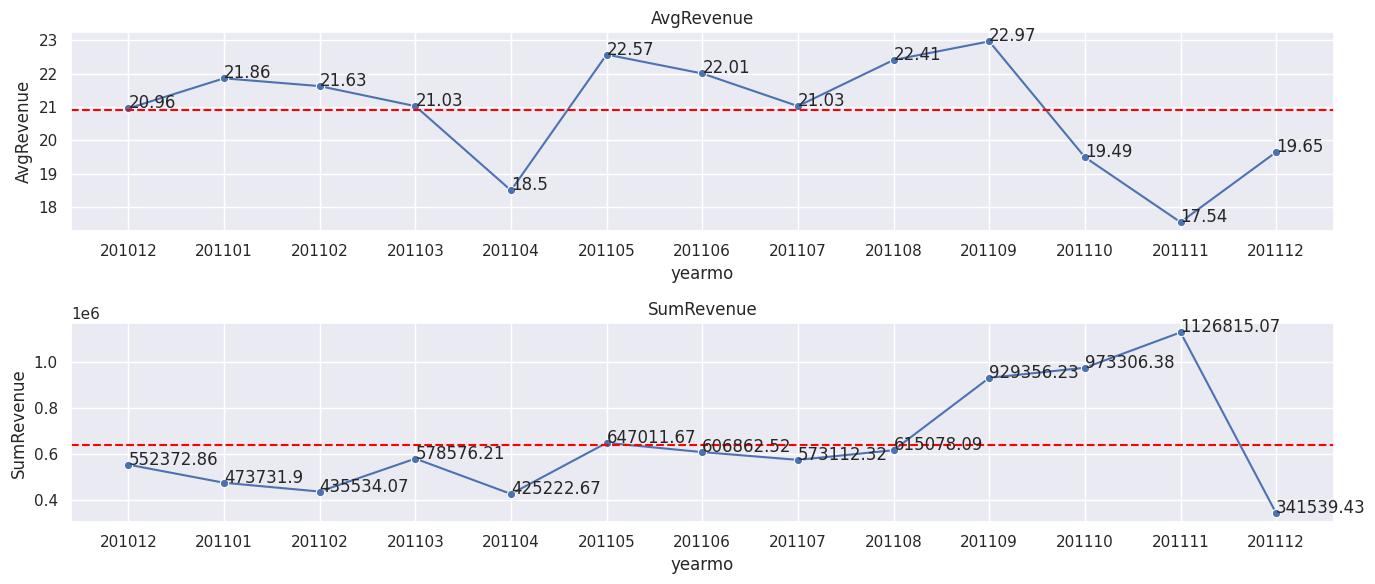

In [347]:
agg_df = df.groupby(['yearmo']).agg(\
   # SumQuantity = ('Quantity','sum'),\
   # AvgQuantity = ('Quantity','mean'),\
   # SumUnitPrice = ('UnitPrice','sum'),\
   # AvgUnitPrice = ('UnitPrice','mean'),\
    SumRevenue = ('Revenue','sum'),\
    AvgRevenue = ('Revenue','mean')).reset_index()

cols = sorted([c for c in agg_df.columns if c not in ['date','yearmo','year','month','day']])
rows = len(cols)

fig, ax = plt.subplots(rows, 1, figsize=(14, 6))
for i,y in enumerate(cols):
    ax[i] = sns.lineplot(data=agg_df, x='yearmo', y=y, ax=ax[i], marker = 'o')
    ax[i].set_title(y)
    
    ax[i].axhline(y=agg_df[y].mean(), color='red', linestyle='--')
    
    for x,y in zip(agg_df['yearmo'], agg_df[y]):
        ax[i].annotate(text=str(np.round(y,2)), xy=(x,y))
    
plt.tight_layout()
plt.show()


#### Monthly Percent Change Revenue

Defined as the change in revenue in a given month

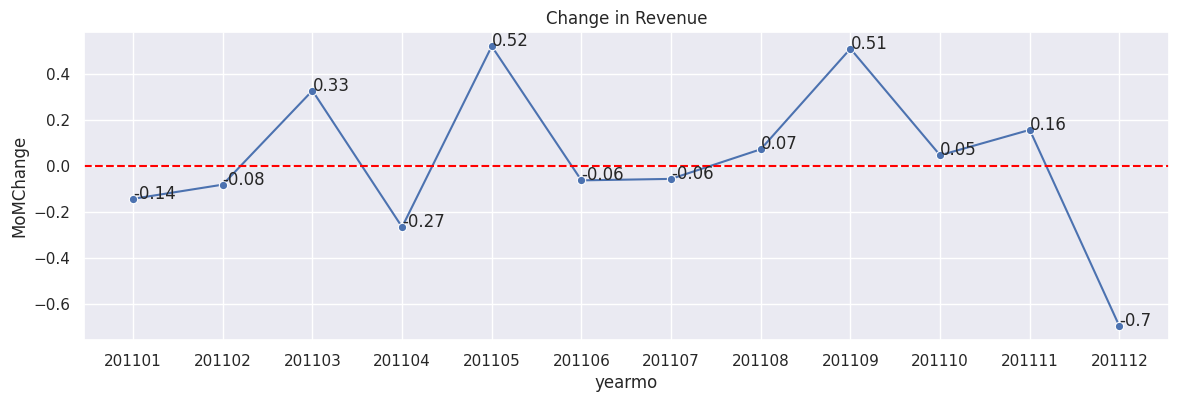

In [348]:
agg_df = df[['yearmo','Revenue']].groupby(['yearmo']).agg(total_revenue = ('Revenue','sum')).reset_index()

agg_df['MoMChange'] = agg_df.total_revenue.pct_change()

sns.set(rc={"figure.figsize":(14, 4)})
ax = sns.lineplot(data=agg_df, x='yearmo', y='MoMChange', marker = 'o')
# add reference line
ax.axhline(y=0, color='red', linestyle='--')
ax.set_title('Change in Revenue')

for x,y in zip(agg_df['yearmo'], agg_df['MoMChange']):
    ax.annotate(text=str(np.round(y,2)), xy=(x,y))


#### Monthly Active Customers

Defined as the unique count of customers in a given month

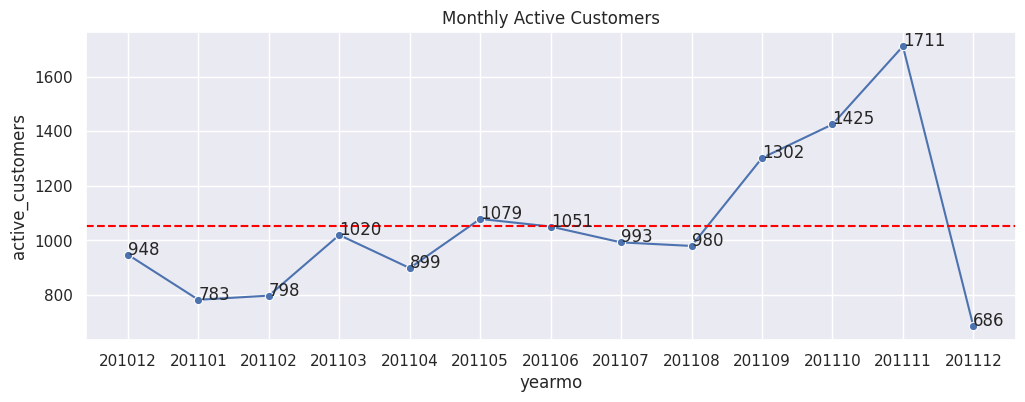

In [349]:
agg_df = df[['yearmo','CustomerID']].groupby(['yearmo']).agg(active_customers = ('CustomerID','nunique')).reset_index()

sns.set(rc={"figure.figsize":(12, 4)})
ax = sns.lineplot(data=agg_df, x='yearmo', y='active_customers', marker = 'o')

# add reference line
plt.axhline(y=agg_df.active_customers.mean(), color='red', linestyle='--')
ax.set_title('Monthly Active Customers')

#Add Labels
for x,y in zip(agg_df['yearmo'], agg_df['active_customers']):
    ax.annotate(text=str(y), xy=(x,y))
    


#### Monthly Percent Change Customers

Defined as the percent change in the number of unique customers per month

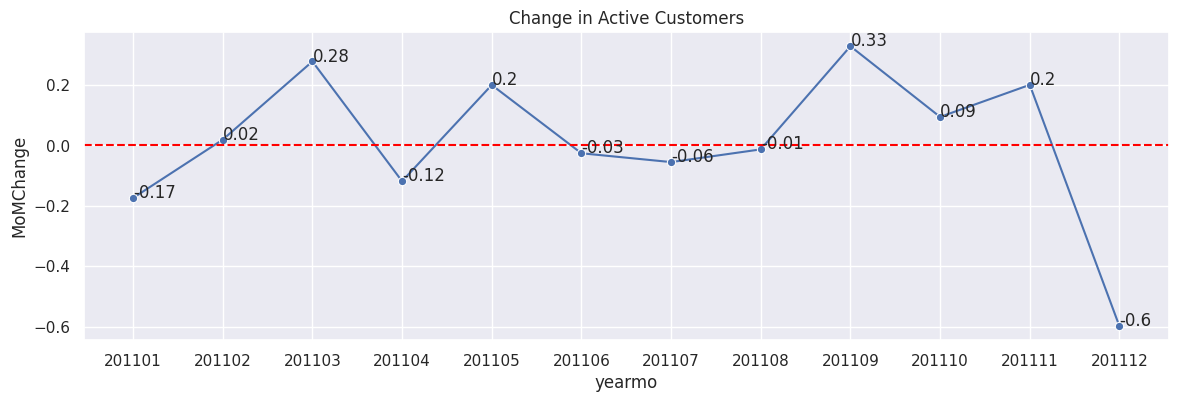

In [350]:
agg_df = df[['yearmo','CustomerID']].groupby(['yearmo']).agg(active_customers = ('CustomerID','nunique')).reset_index()

agg_df['MoMChange'] = agg_df.active_customers.pct_change()


sns.set(rc={"figure.figsize":(14, 4)})
ax = sns.lineplot(data=agg_df, x='yearmo', y='MoMChange', marker = 'o')
# add reference line
ax.axhline(y=0, color='red', linestyle='--')
ax.set_title('Change in Active Customers')

for x,y in zip(agg_df['yearmo'], agg_df['MoMChange']):
    ax.annotate(text=str(np.round(y,2)), xy=(x,y))


#### New Customer Ratio

Defined as how many new customers in a given month.  Determined by flagging the first purchase by customer. 

In [485]:
# First purchases extracted
#mask = df.groupby(['CustomerID']).first().reset_index()#.reset_index().dropna().drop_duplicates()
#mask = df[['InvoiceDate','CustomerID']].groupby(['CustomerID']).first().reset_index()
mask = df.groupby('CustomerID',as_index=False).agg(yearmo = ('yearmo','first'))

#Creating keys to 
keys = list(mask.columns.values)
i1 = df.set_index(keys).index
i2 = mask.drop_duplicates().set_index(keys).index

new_df = pd.concat([\
                    df[~i1.isin(i2)].assign(NewCustomerFlag = 0)\
                    , df[i1.isin(i2)].assign(NewCustomerFlag = 1)\
                   ])

In [ ]:
   
    fig, ax = plt.subplots(2, 1, figsize=(10, 12))
        for i,y in enumerate(sorted([c for c in agg_df.columns if c != 'date'])):
            sns.lineplot(data=agg_df, x='date', y=y, ax=ax[i])
            ax[i].set_title(y)
        plt.tight_layout()
        plt.show()

In [518]:
[c for c in agg_df.columns if c != 'yearmo']

['ReturningCustomerCount', 'NewCustomerCount']

In [533]:
agg_df

,yearmo,ReturningCustomerCount,NewCustomerCount,NewCustomerRatio
12,201012,0.0,948,inf
0,201101,362.0,421,1.162983
1,201102,418.0,380,0.909091
2,201103,580.0,440,0.758621
3,201104,600.0,299,0.498333
4,201105,800.0,279,0.348750
5,201106,816.0,235,0.287990
6,201107,802.0,191,0.238155
7,201108,813.0,167,0.205412
8,201109,1004.0,298,0.296813


In [548]:
agg_df

,yearmo,ReturningCustomerCount,NewCustomerCount,NewCustomerRatio
12,201012,0.0,948,0.000000
0,201101,362.0,421,1.162983
1,201102,418.0,380,0.909091
2,201103,580.0,440,0.758621
3,201104,600.0,299,0.498333
4,201105,800.0,279,0.348750
5,201106,816.0,235,0.287990
6,201107,802.0,191,0.238155
7,201108,813.0,167,0.205412
8,201109,1004.0,298,0.296813


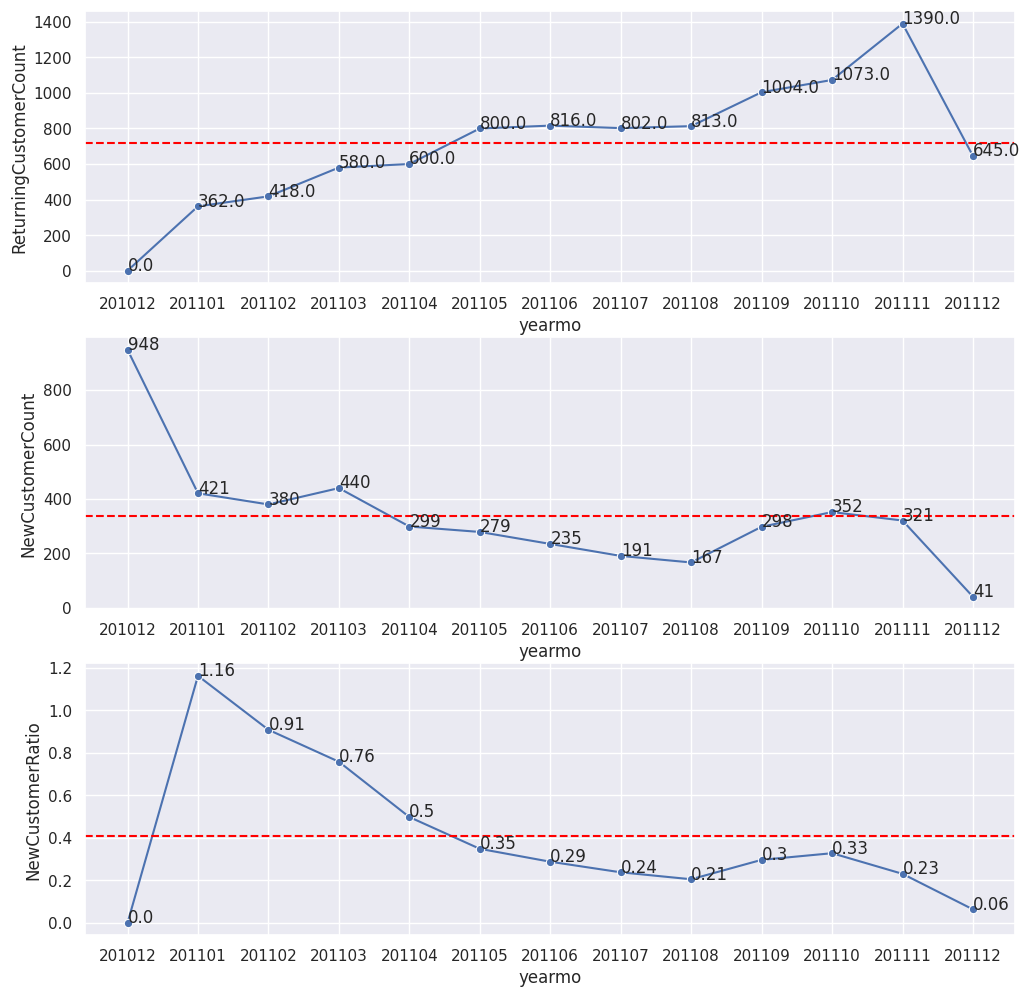

In [560]:
agg_df = new_df.loc[\
new_df.NewCustomerFlag == 0].groupby(['yearmo']).agg(ReturningCustomerCount = ('CustomerID','nunique')).reset_index().\
merge(\
      new_df.loc[new_df.NewCustomerFlag == 1].groupby(['yearmo']).agg(NewCustomerCount = ('CustomerID','nunique')).reset_index()\
, on='yearmo', how='outer').fillna(0).sort_values(['yearmo'])\
.assign(NewCustomerRatio = agg_df.NewCustomerCount / agg_df.ReturningCustomerCount)\
.replace([np.inf, -np.inf], 0)

#agg_df['MoMChange'] = agg_df.active_customers.pct_change()

fig, ax = plt.subplots(3, 1, figsize=(12, 12))
for i,c in enumerate([c for c in agg_df.columns if c != 'yearmo']):
    ax[i] = sns.lineplot(data=agg_df, x='yearmo', y=c, marker = 'o' , ax=ax[i])
    # add reference line
    ax[i].axhline(y=agg_df[c].mean(), color='red', linestyle='--')
    #ax[i].set_title(c)

    for x,y in zip(agg_df['yearmo'], agg_df[c]):
        ax[i].annotate(text=str(np.round(y,2)), xy=(x,y))


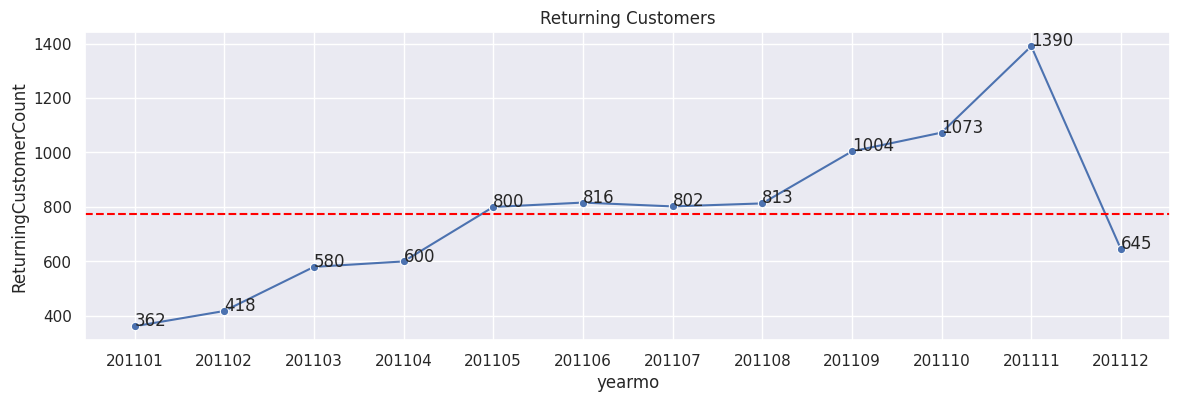

In [514]:
agg_df = new_df.loc[new_df.NewCustomerFlag == 0].groupby(['yearmo']).agg(ReturningCustomerCount = ('CustomerID','nunique')).reset_index()

#agg_df['MoMChange'] = agg_df.active_customers.pct_change()


sns.set(rc={"figure.figsize":(14, 4)})
ax = sns.lineplot(data=agg_df, x='yearmo', y='ReturningCustomerCount', marker = 'o')
# add reference line
ax.axhline(y=agg_df.ReturningCustomerCount.mean(), color='red', linestyle='--')
ax.set_title('Returning Customers')

for x,y in zip(agg_df['yearmo'], agg_df['ReturningCustomerCount']):
    ax.annotate(text=str(np.round(y,2)), xy=(x,y))


,yearmo,ReturningCustomerCount,NewCustomerCount
0,201101,362,421
1,201102,418,380
2,201103,580,440
3,201104,600,299
4,201105,800,279
5,201106,816,235
6,201107,802,191
7,201108,813,167
8,201109,1004,298
9,201110,1073,352


In [504]:
new_df.groupby(['yearmo','CustomerID','NewCustomerFlag']).agg(NewCustomerCount = ('CustomerID','count'))\
.reset_index().sort_values(['CustomerID','NewCustomerFlag']).NewCustomerFlag.describe()

count    13675.000000
mean         0.319707
std          0.466380
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: NewCustomerFlag, dtype: float64

In [489]:
new_df.groupby(['yearmo']).agg(CustomerCount = ('CustomerID','nunique')).reset_index()

,yearmo,CustomerCount
0,201012,948
1,201101,783
2,201102,798
3,201103,1020
4,201104,899
5,201105,1079
6,201106,1051
7,201107,993
8,201108,980
9,201109,1302


In [488]:
new_df.loc[new_df.NewCustomerFlag == 0].groupby(['yearmo']).agg(ReturningCustomerCount = ('CustomerID','nunique')).reset_index()

,yearmo,ReturningCustomerCount
0,201101,362
1,201102,418
2,201103,580
3,201104,600
4,201105,800
5,201106,816
6,201107,802
7,201108,813
8,201109,1004
9,201110,1073
